In [ ]:
# My analysis for the OpenAI to Z Challenge begins here.

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import show
import folium
from shapely.geometry import Polygon, Point

# --- Data Acquisition Libraries ---
import srtm
from pystac_client import Client
import requests

# --- Visualization ---
import matplotlib.pyplot as plt

# --- Display settings for Jupyter ---
%matplotlib inline

print("Libraries imported successfully.")

Libraries imported successfully.


The DEM file will be saved to this exact location: /Users/vijayshankarchamakuri/oai_z_challenge/colombia_aoi_dem.tif

make: Nothing to be done for `download'.
make: Nothing to be done for `all'.
cp SRTM1.vrt SRTM1.7df830f576ff481389fad2a8c65c3464.vrt
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 -projwin -74.0 1.0 -73.5 0.5 SRTM1.7df830f576ff481389fad2a8c65c3464.vrt /Users/vijayshankarchamakuri/oai_z_challenge/colombia_aoi_dem.tif
rm -f SRTM1.7df830f576ff481389fad2a8c65c3464.vrt
Elevation data successfully saved.

Opening and visualizing the DEM file...


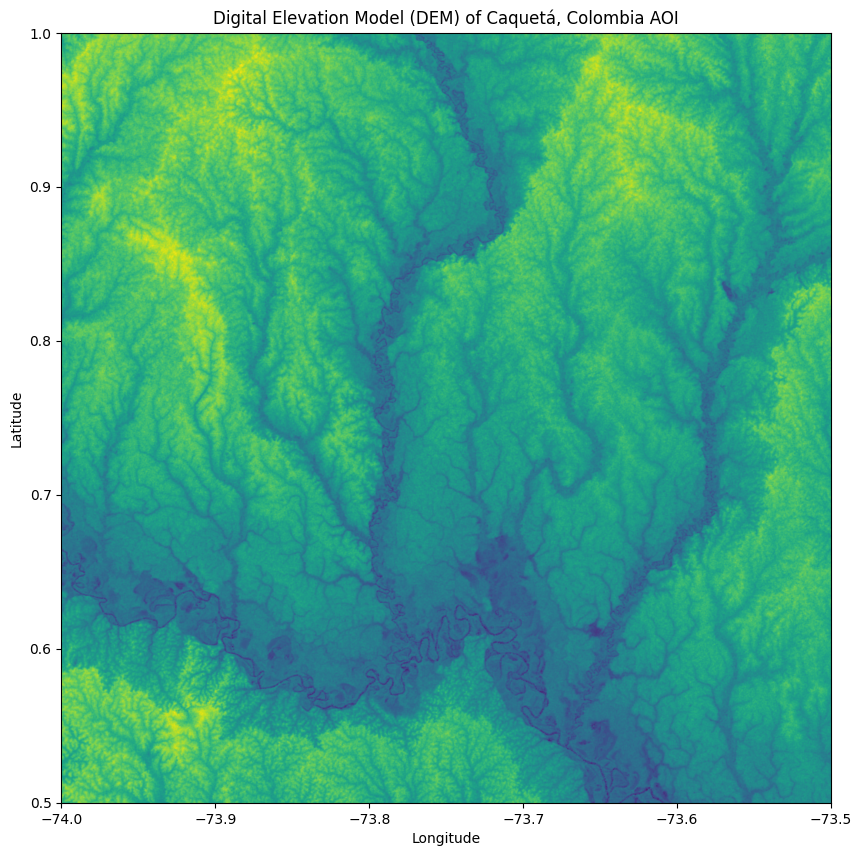


DEM Metadata:
{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 1801, 'height': 1801, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.0002777777777777778, 0.0, -74.00013888888888,
       0.0, -0.0002777777777777778, 1.000138888888889)}


In [5]:
import elevation
import os
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# --- Step 1: Define an ABSOLUTE path for the output file ---
# This forces the file to be saved in the same directory as our notebook.
notebook_dir = os.getcwd()
output_file = os.path.join(notebook_dir, 'colombia_aoi_dem.tif')
print(f"The DEM file will be saved to this exact location: {output_file}")

# --- Step 2: Manually delete the file if it already exists ---
# This is a robust way to ensure we are creating a fresh file.
if os.path.exists(output_file):
    os.remove(output_file)
    print(f"Removed existing (potentially corrupt) file: {output_file}")

# --- Step 3: Re-run the download command WITHOUT the 'overwrite' argument ---
# Define the geographic bounds for our clip
bounds = (min_lon, min_lat, max_lon, max_lat)

# This command will now download the SRTM 30m data to a clean slate.
print("\nDownloading and clipping SRTM data for the AOI...")
elevation.clip(bounds=bounds, output=output_file, product='SRTM1')
print(f"Elevation data successfully saved.")

# --- Step 4: Now, open and visualize the file ---
print("\nOpening and visualizing the DEM file...")
with rasterio.open(output_file) as src:
    dem_array = src.read(1)
    dem_meta = src.meta
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    show(dem_array, ax=ax, cmap='viridis', transform=src.transform)
    plt.title("Digital Elevation Model (DEM) of Caquetá, Colombia AOI")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

print("\nDEM Metadata:")
print(dem_meta)

In [11]:
# Calculate the center of our AOI for the map
# Ensure that `aoi_gdf` exists and has at least one geometry
# Step 1: Reproject the AOI to a projected CRS (e.g., UTM Zone 18N for Colombia)
aoi_projected = aoi_gdf.to_crs(epsg=32618)  # UTM Zone 18N (adjust if needed)

# Step 2: Calculate centroid in projected CRS, then extract its lat/lon by converting back to EPSG:4326
centroid = aoi_projected.geometry.centroid.iloc[0]
centroid_latlon = gpd.GeoSeries([centroid], crs="EPSG:32618").to_crs(epsg=4326).geometry.iloc[0]

center_lat = centroid_latlon.y
center_lon = centroid_latlon.x


# Create a folium map object, centered on our AOI
m = folium.Map(location=[center_lat, center_lon], zoom_start=9, tiles="CartoDB positron")

# Add a satellite layer for context from Esri
folium.TileLayer(
    'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri',
    name='Esri Satellite',
    overlay=False,
    control=True
).add_to(m)

# Add our AOI polygon to the map so we can see the boundary
folium.GeoJson(
    aoi_gdf,
    style_function=lambda x: {'fillColor': 'blue', 'color': 'blue', 'weight': 2, 'fillOpacity': 0.1}
).add_to(m)

# Add a layer control to switch between basemaps
folium.LayerControl().add_to(m)

print("Displaying interactive map of the AOI. You can zoom, pan, and switch layers using the icon in the top right.")
m


Displaying interactive map of the AOI. You can zoom, pan, and switch layers using the icon in the top right.


In [15]:
from shapely.geometry import shape  # Import this if not already
from rasterio import features
def find_flat_anomalies(dem_path, roughness_threshold=5):
    """
    Identifies flat areas in a DEM by calculating terrain roughness.
    
    Args:
        dem_path (str): Path to the Digital Elevation Model GeoTIFF file.
        roughness_threshold (int): The maximum roughness value to be considered 'flat'.
                                   
    Returns:
        geopandas.GeoDataFrame: A GeoDataFrame with polygons of the flat areas.
    """
    with rasterio.open(dem_path) as src:
        dem = src.read(1).astype(float)
        profile = src.profile
        
        # Pad the array to handle edges
        padded_dem = np.pad(dem, 1, mode='edge')
        windows = np.lib.stride_tricks.sliding_window_view(padded_dem, (3, 3))
        
        # Calculate standard deviation in the 3x3 window
        roughness = np.std(windows, axis=(2, 3))
        
        # Find pixels where roughness is below the threshold and elevation > 0
        flat_areas_mask = (roughness <= roughness_threshold) & (dem > 0)
        
        # Convert mask to vector polygons
        shapes_gen = features.shapes(
            flat_areas_mask.astype(np.uint8),
            mask=flat_areas_mask,
            transform=src.transform
        )
        
        # Convert shapes to geometries
        geometries = [shape(geom) for geom, value in shapes_gen if value == 1]
        
        if not geometries:
            return gpd.GeoDataFrame(geometry=[], crs=profile['crs'])
        
        gdf = gpd.GeoDataFrame(geometry=geometries, crs=profile['crs'])
        gdf = gdf.to_crs(epsg=32618)  # UTM Zone 18N, for Caquetá, Colombia
        gdf['area_sq_meters'] = gdf.geometry.area
        
        return gdf

# --- Run the function ---
print("Searching for flat areas in the DEM...")
flat_areas_gdf = find_flat_anomalies(output_file, roughness_threshold=2)

# Filter out very small flat areas
min_area_sq_meters = 5000
significant_anomalies = flat_areas_gdf[flat_areas_gdf['area_sq_meters'] > min_area_sq_meters].copy()

# Calculate centroids for labeling or visualization
significant_anomalies['centroid'] = significant_anomalies.geometry.centroid

print(f"Found {len(significant_anomalies)} significant flat areas.")
significant_anomalies.head()


Searching for flat areas in the DEM...
Found 615 significant flat areas.


,geometry,area_sq_meters,centroid
1,"POLYGON ((613690.233 110563.207, 613690.252 11...",20881.925370,POINT (613815.291 110521.372)
4,"POLYGON ((612299.362 110317.115, 612299.381 11...",9491.711235,POINT (612339.568 110240.358)
5,"POLYGON ((636935.419 110386.923, 636935.465 11...",37023.320547,POINT (637040.485 110270.816)
9,"POLYGON ((637244.599 110233.489, 637244.61 110...",40820.661787,POINT (637291.008 110125.307)
14,"POLYGON ((637770.327 109650.194, 637770.361 10...",14239.839447,POINT (637810.539 109581.624)


In [18]:
# Create the final map, centered on our AOI
final_map = folium.Map(location=[center_lat, center_lon], zoom_start=9, tiles="CartoDB positron")

# Add the satellite layer for context
folium.TileLayer(
    'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri',
    name='Esri Satellite',
    overlay=False,
    control=True
).add_to(final_map)

# Add the AOI boundary so we can see our search area
folium.GeoJson(
    aoi_gdf,
    name="Area of Interest",
    style_function=lambda x: {'fillColor': 'blue', 'color': 'blue', 'weight': 2, 'fillOpacity': 0.1}
).add_to(final_map)

# Add the detected anomalies to the map
if not significant_anomalies.empty:
    # Create a FeatureGroup for the anomalies so we can toggle them on/off
    anomalies_fg = folium.FeatureGroup(name="Potential Sites (Flat Areas)")
    
    # IMPORTANT: Folium needs coordinates in Lat/Lon (EPSG:4326).
    # We must convert our anomaly data to this coordinate system first.
    anomalies_wgs84 = significant_anomalies.to_crs("EPSG:4326")
    
    for idx, row in anomalies_wgs84.iterrows():
        # CORRECTED: Calculate the centroid from the *re-projected* geometry
        centroid = row.geometry.centroid
        
        # Add a small red circle marker for each anomaly
        folium.CircleMarker(
            location=[centroid.y, centroid.x],
            radius=5,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.7,
            popup=f"Anomaly ID: {idx}<br>Area: {row.area_sq_meters:.2f} m²"
        ).add_to(anomalies_fg)
        
    anomalies_fg.add_to(final_map)

# Add a layer control to switch layers on and off
folium.LayerControl().add_to(final_map)

# --- NEW: Save the map to an HTML file ---
output_map_file = 'fullscreen_anomaly_map.html'
final_map.save(output_map_file)

print(f"Map has been saved to '{output_map_file}'.")
print("You can now open this file from the Jupyter file browser for a full-screen view.")

# Display the map in the notebook as well
final_map

Map has been saved to 'fullscreen_anomaly_map.html'.
You can now open this file from the Jupyter file browser for a full-screen view.


In [ ]:
import openai
import base64
import os
from IPython.display import display, Markdown

# --- Set up your API key ---
os.environ["OPENAI_API_KEY"] = "YOUR_API_KEY_SHOULD_GO_HERE"  # Replace with your actual OpenAI API key
openai.api_key = os.environ["OPENAI_API_KEY"]

# --- Helper: Encode image as base64 string ---
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# --- Analyze one image with GPT-4o Vision ---
def analyze_site_with_gpt(image_path):
    if not os.path.exists(image_path):
        return f"Error: Image file not found at '{image_path}'"

    base64_image = encode_image(image_path)

    prompt_messages = [
        {
            "role": "system",
            "content": "You are an expert in satellite archaeology. You analyze geospatial imagery for signs of ancient human-made patterns like earthworks, geoglyphs, linear roads, or clustered mounds."
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": (
                        "In this image, red dots represent candidate sites from a digital elevation model. "
                        "Please describe any visible patterns — such as clusters, lines, or geometry — and evaluate whether they are likely natural or man-made features. Explain clearly."
                    )
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/png;base64,{base64_image}"
                    }
                }
            ]
        }
    ]

    try:
        response = openai.chat.completions.create(
            model="gpt-4o",
            messages=prompt_messages,
            max_tokens=1000
        )
        return response.choices[0].message.content
    except Exception as e:
        return f"An error occurred: {e}"

# --- List of site images to analyze ---
site_images = [
    "site_1.png",
    "site_2_linear_feature.png",
    "site_3_river_pattern.png"
]

# --- Analyze all images in a loop ---
for image_path in site_images:
    result = analyze_site_with_gpt(image_path)
    display(Markdown(f"## 🛰️ AI Analysis for `{image_path}`\n\n---\n\n{result}\n\n---"))


## 🛰️ AI Analysis for `site_1.png`

---

The image shows red dots marking candidate sites derived from a digital elevation model. Here's an analysis of visible patterns and their likely origins:

1. **Clusters of Dots**: 
   - The dots are predominantly clustered along the meandering path of a river or stream. This clustering might suggest locations influenced by water flow or human settlements historically established near water sources.
   - There are also clusters situated near other visible clearings, indicating potential human activity or natural clearings.

2. **Linear Arrangements**: 
   - A few dots appear to align loosely with the riverbank, which might indicate natural sediments, erosion patterns, or possibly ancient trails following the natural geographical feature of the river.
    
3. **Isolation of Dots**:
   - Some dots are scattered further away from the water and are more isolated. These may represent isolated natural features such as small hills or mounds protruding from the landscape or could signify man-made structures like ancient paths or roads.

4. **Overall Geometry**: 
   - The lack of strict geometric patterns reduces the likelihood that these marks are purely remnants of human-made structures such as buildings or regular geometric fields. However, human settlement patterns often follow natural geographic features, explaining the clustering near the river.

**Natural vs. Man-made Conclusion**:
- **Natural Features**: The alignment and clustering along a river suggest natural geological formations or erosion patterns.
- **Possible Human Influence**: The clustering near water bodies and clearings hints at potential human interaction, maybe for settlement or agriculture. However, without more regular patterns or alignments, definitive man-made identification is uncertain.

Further analysis, including historical context or archaeological data, would be needed for a more definitive conclusion.

---

## 🛰️ AI Analysis for `site_2_linear_feature.png`

---

The image shows red dots distributed in a discernible pattern. These dots predominantly align along a curving path, suggesting they follow natural geographic features, likely a river or a similar waterway. This is evident from the way they meander, resembling the typical flow of a river system rather than straight lines or regular geometric shapes.

Clusters of dots appear at various points along this path. These might indicate confluences, bends, or other significant points of interest along the river, which could attract both natural sediment deposits or human activity.

The linear, non-geometric arrangement strongly suggests that this pattern is more likely natural than man-made. The alignment with what appears to be a river indicates the dots are associated with environmental features or phenomena, possibly elevation changes influenced by the water.

Overall, this configuration supports the idea of a natural formation rather than a human-engineered structure.

---

## 🛰️ AI Analysis for `site_3_river_pattern.png`

---

In the image, red dots are scattered alongside and around a meandering river. Here's the analysis:

1. **Spatial Distribution**: The red dots do not form any distinct geometric patterns such as lines or grids. They are dispersed irregularly on both sides of the river.

2. **Clustering**: Some of the dots appear to be clustered near bends in the river, but there is no apparent consistent pattern of clustering that suggests man-made formations.

3. **Alignment**: There are no straight lines or alignments visible among the dots which might imply human-made structures like roads or walls.

4. **Contextual Environment**: The presence of a winding river suggests natural processes. The location of dots near river bends could indicate natural occurrences such as erosion sites or riverbank deposits.

Given these observations, it is more likely that the red dots represent natural features, possibly identified based on variations in elevation due to riverine processes, rather than man-made ones.

---